# Step-by-step Guide: Modeling with Phydrus

*Authors: R.A. Collenteur & M. Vremec*

This notebook is part of a manuscript that is currently being prepared (spring 2021): 

*R.A. Collenteur, M. Vremec, J. Simunek, and G. Brunetti, (in preparation) pHydrus: an open source Python package for the Hydrus-1D model.*

---

This Notebook presents the basics steps to create a Phydrus model simulating water flow through the vadose zone. In the presented example, the workflow is divided into several steps, to demonstrate the usage of Phydrus methods:

1. Import the Phydrus package
2. Create a pHydrus Model instance.
3. Provide time information.
4. Add flow and transport processes.
5. Add materials
6. Create and add the soil profile.
7. Add atmospheric boundary data.
8. Add observation nodes.
9. Write input files and run Hydrus-1D.
10. Read and plot the results.

### 1. Import the required packages

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import phydrus as ps
ps.show_versions()

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.19.2
Pandas version: 1.2.1
Phydrus version: 0.3.0b
Matplotlib version: 3.3.2


### Step 2. Create a pHydrus Model instance.
In the code block below a `Model` instance is created. The path to the Hydrus-1D executable has to be set at this stage. Phydrus will check the executable, and raise an Error if it is not found. 

In [2]:
# Workspace Folder where the Hydrus files are to be stored
ws = "output"
exe = os.path.join(os.getcwd(), "../hydrus")  # path to the Hydrus-1D executable

# Create model
ml = ps.Model(exe_name=exe, ws_name=ws)

### Step 3. Provide time information.

In [3]:
ml.add_time_info(tinit=0, tmax=730, print_times=True);

### Step 4. Add flow and transport processes.
In this step a model for the water flow is selected and top and bottom boundary conditions, using the `ml.add_waterflow` method. After that, we can use the `get_empty_material_df` method to obtain an empty DataFrame to define our soil hydraulic parameters for the different soil materials. In this example, the model contains to soil materials.

In [4]:
ml.add_waterflow(model=0, top_bc=3, bot_bc=4)

### Step 5. Add materials.

In [5]:
# Add materials
m = ml.get_empty_material_df(n=2)
m.loc[0:2] = [[0.0, 0.34, 0.01, 1.47, 13, 0.5],
              [0.0, 0.36, 0.02, 1.52, 50, 0.5]]
ml.add_material(m)

### Step 6. Create and add the soil profile.


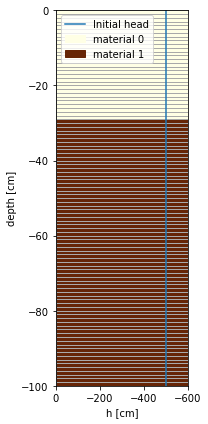

In [6]:
bottom = [-30, -100]  # Depth of the soil layer bottoms
ihead = -500  # Determine initial pressure head

profile = ps.create_profile(bot=bottom, dx=1, h=ihead, mat=[1, 2])
ml.add_profile(profile)
ml.plots.profile(figsize=(3,6));

### Step 7. Add atmospheric boundary data.
Atmospheric boundary condition can be added easily by reading in a CSV file using Pandas `read_csv` method and adding it to the model. 

In [7]:
atm = pd.read_csv("../data/atmosphere.csv", index_col=0)
ml.add_atmospheric_bc(atm, hcrits=0)

### Step 8. Add observation nodes.

In [8]:
#Number of the node
ml.add_obs_nodes([-30, -60])

### Step 9. Write input files and run Hydrus-1D.
Before we can simulate, we write all model information to files. 

In [9]:
ml.write_input()
ml.simulate()

INFO: Successfully wrote output/SELECTOR.IN
INFO: Successfully wrote output/PROFILE.DAT
INFO: Successfully wrote output/ATMOSPH.IN
INFO: Hydrus-1D Simulation Successful.


CompletedProcess(args=['/Users/raoulcollenteur/Github/phydrus/phydrus/examples/phydrus_paper/Ex1/../hydrus', 'output', '-1'], returncode=0)

### Step 10. Read and plot the results.
Plot pressure for soil column at the end of the simulation. Plot the drainage over time

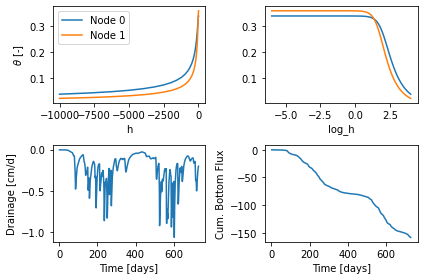

In [10]:
fig, axes = plt.subplots(2,2, figsize=(6,4))

[ax1, ax2] = ml.plots.soil_properties(axes=axes[0]);
[ax3, ax4] = ml.plots.water_flow("Bottom Flux", axes=axes[1]);

ax1.set_ylabel("$\\theta$ [-]")
ax3.set_ylabel("Drainage [cm/d]")

ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()

plt.tight_layout()
plt.savefig("../figures/figure_1.pdf", bbox_inches="tight", dpi=300)

### 9c. Plot the water content over time

[Text(0, 0, 'Jan-07'), Text(365, 0, 'Jan-08'), Text(730, 0, 'Jan-09')]

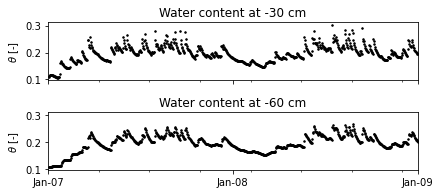

In [11]:
df = ml.read_obs_node()

fig, [ax0, ax1] = plt.subplots(2,1, figsize=(6,3), sharex=True, sharey=True)
df[ml.obs_nodes[0]]["theta"].plot(ax=ax0, marker=".", c="k", linestyle="", markersize=3)
ax0.set_title("Water content at -30 cm")
ax0.set_ylabel(r"$\theta$ [-]")

df[ml.obs_nodes[1]]["theta"].plot(ax=ax1, marker=".", c="k", linestyle="", markersize=3)
ax1.set_title("Water content at -60 cm")
ax1.set_ylabel(r"$\theta$ [-]")
plt.tight_layout()
ax1.set_xlabel("")
ax1.set_xlim(0,730)
ax1.set_xticks([0,365,730])
ax1.set_xticklabels(["Jan-07", "Jan-08", "Jan-09"])
#plt.savefig("../../figures/water_content.eps", bbox_inches="tight", dpi=300)